# AISE4010 — Assignment 1 
### Time Series Forecasting with Autoregressive Models and MLP 

**Grade:** 100 points

## Instructions
Follow these steps before submitting your assignment:
1. Complete the notebook.
2. Make sure **all plots have axis labels**.
3. When finished, go to **Kernel → Restart & Run All** to ensure a clean, error‑free run.
4. Fix any errors until your notebook runs without problems.
5. Submit **one completed notebook** per group to OWL by the deadline.
6. Reference all external code and documentation you use.

## Dataset 
- **File:** `weather.csv`
- **Location:** Szeged, Hungary
- **Frequency:** Daily (fixed calendar index)
- **Time span:** ≈ 2006–2016
- **Target:** `Temperature (C)`
- **Key variables:** Temperature (C), Pressure (millibars), Humidity, Appar Temperature (C), Wind Speed (km/h), Wind Bearing (degrees), Visibility (km)


## Question 1: Data Preprocessing (25%)

### Q1.1 Exploratory Data Analysis (2%)
1. Load the dataset and print the **first 6 rows**.  
2. Encode categorical variables (one‑hot). *(If none, report "none.")*


In [1]:
# Answer to Q1.1.1

# Import packages
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read data
weather = pd.read_csv('weather.csv')
weather['Formatted Date'] = pd.to_datetime(weather['Formatted Date'])

# Display first 6 rows
weather.head(6)

,Formatted Date,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
0,2005-12-31,0.6,-4.0,0.89,17.1,140.0,10.0,1016.7
1,2006-01-01,4.1,-0.2,0.82,21.2,143.0,11.3,1012.0
2,2006-01-02,5.3,1.8,0.85,17.8,165.0,8.5,1010.4
3,2006-01-03,2.3,0.4,0.90,7.7,253.0,9.2,1021.2
4,2006-01-04,2.3,-0.7,0.91,12.2,35.0,8.4,981.8
5,2006-01-05,2.7,0.4,0.95,9.0,140.0,4.3,935.9


In [3]:
# Answer to Q1.1.2

weather.info()

# There are no categorical variables in the dataset. All variables are numerical or datetime.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4019 entries, 0 to 4018
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Formatted Date            4019 non-null   datetime64[ns]
 1   Temperature (C)           3972 non-null   float64       
 2   Apparent Temperature (C)  4019 non-null   float64       
 3   Humidity                  3979 non-null   float64       
 4   Wind Speed (km/h)         4019 non-null   float64       
 5   Wind Bearing (degrees)    4019 non-null   float64       
 6   Visibility (km)           4019 non-null   float64       
 7   Pressure (millibars)      3972 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 251.3 KB


### Q1.2 Handling Missing Data (11%)
1. Report missingness (**counts & %**) and show a heatmap for **Temperature, Pressure, Humidity**.
2. Use these two imputation methods:\
   a) Forward-fill (FFill).\
   b) Linear time interpolation.
3. Pick one method and save the result as `daily_clean`.
4. **Discussion** Which imputation method did you pick and why?  
5. **Discussion** How might your choice bias trend/seasonality estimates?  
6. **Discussion** Would your choice change if the gap were 30 days instead of 7? Explain briefly.


Missing values (count):
Temperature (C)         47
Pressure (millibars)    47
Humidity                40
dtype: int64

Missing values (percentage):
Temperature (C)         1.17
Pressure (millibars)    1.17
Humidity                1.00
dtype: float64


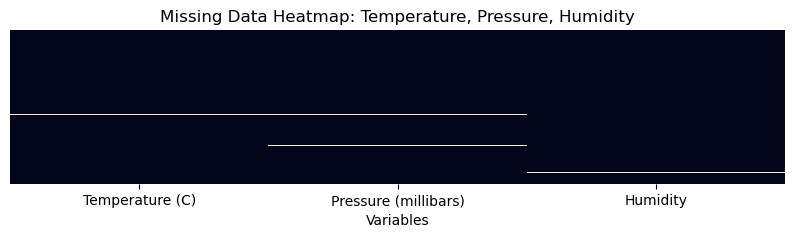

In [2]:
# Answer to Q1.2.1

# Select relevant columns
cols = ['Temperature (C)', 'Pressure (millibars)', 'Humidity']

# Report missingness: counts and percentage
missing_counts = weather[cols].isnull().sum()
missing_percent = weather[cols].isnull().mean() * 100

print("Missing values (count):")
print(missing_counts)
print("\nMissing values (percentage):")
print(missing_percent.round(2))

# Show heatmap of missing values
plt.figure(figsize=(10, 2))
sns.heatmap(weather[cols].isnull(), cbar=False, yticklabels=False)
plt.xlabel("Variables")
plt.title("Missing Data Heatmap: Temperature, Pressure, Humidity")
plt.show()

In [ ]:
# Answer to Q1.2.2

In [ ]:
# Answer to Q1.2.3

**Answer to Q1.2.4**: 


**Answer to Q1.2.5**: 


**Answer to Q1.2.6**: 


### Q1.3 Stationarity Analysis (12%)
1. Extract the **univariate** series `Temperature_Series = daily_clean['Temperature (C)']` and `Pressure_Series = daily_clean['Pressure (millibars)'].  
2. Report the results of a stationarity test (**ADF** or **KPSS**) for both series.
3. **Discussion:** Explain your conclusion about stationary analysis of your results. 
4. Apply differencing on both series and plot **before/after** and report the stationary test results of your choice on differenced series.   
5. **Discussion:** Explain the reason for your choice of differencing technique for each series.
6. **Discussion:** Would you difference a series that is already stationary by ADF? When might that still help?

In [ ]:
# Answer to Q1.3.1

In [ ]:
# Answer to Q1.3.2

**Answer to Q1.2.3**: 


In [ ]:
# Answer to Q1.3.4

**Answer to Q1.2.5**: 


**Answer to Q1.2.6**: 


## Question 2: Model-Based Techniques (35%)

### Q2.1 ARIMA model identification and forecasting (20%)
1. Use `Temperature_Series` to plot **ACF/PACF** and list the choice of candidate order set for ARIMA: (p,d,q).  
2. **Discussion:** Explain the reasons for your choice of (p,d,q).
3. Select the orders by **AIC** using the training set (hold out the last **365 days** for testing).  
4. Fit the selected ARIMA on the training set and evaluate the predictions' **MAE/MSE** on the test set.
5. Plot predictions with **95% CI**.
6. Forecast the **next 365 days** and visualize with historical context and **95% CI**.


In [ ]:
# Answer to Q2.1.1

**Answer to Q2.1.2**: 


In [ ]:
# Answer to Q2.1.3

In [ ]:
# Answer to Q2.1.4

In [ ]:
# Answer to Q2.1.5

In [ ]:
# Answer to Q2.1.6

### Q2.2 SARIMA forecasting (15%)

1. Derive a **monthly** series from `daily_clean` and fit a **SARIMA** with seasonal period **12**. Hold out the **last 24 months** as test set for prediction. 
2. Report the predictions' **MAE/MSE**.
3. Plot the the prediction with **95% CI** 
4.  **Discussion:** Compare the ARIMA and SARIMA predictions and explain your findings.


In [ ]:
# Answer to Q2.2.1

In [ ]:
# Answer to Q2.2.2

In [ ]:
# Answer to Q2.2.3

**Answer to Q2.2.4**: 


## Question 3: Neural Networks for Time Series Forecasting (40%)
Use `daily_clean` for all parts.

### Q3.1 Sliding Window for Time Series — Univariate (2%)
1. Restructure **Temperature**: past **10 days** → **next day**.

2. Hold out last 20% as test set.


In [ ]:
# Answer to Q3.1.1

In [ ]:
# Answer to Q3.1.2

### Q3.2 MLP — Univariate (18%)
1. Build an MLP with one hidden layer of 64 neurons, ReLu activation, Adam optimizer with learning rate of 0.001 and batch_size=32, and train it for 20 epochs. 
2. Report **RMSE/MAE**.
3. Plot **two figures**: (1) **last 100 test points** (true vs. predicted), (2) **scatter (true vs. predicted)** with the **y = x** line.
4. **Discussion:** Compare ARIMA vs. the univariate MLP in **RMSE/MAE** and **plots**. Which patterns does each capture better? 
5. **Discussion:** Would increasing the input window beyond 10 days help? Why or why not?


In [ ]:
# Answer to Q3.2.1

In [ ]:
# Answer to Q3.2.2

In [ ]:
# Answer to Q3.2.3

**Answer to Q3.2.4**: 


**Answer to Q3.2.5**: 


### Q3.3 MLP — Multivariate (20%)
1. Use **Temperature & Pressure** for the past **10 days** as the inputs and **next‑day Temperature** as the target. 
2. Hold out last 20% as test set.
3. Build a Multivariate MLP with one hidden layer of 64 neurons, ReLu activation, Adam optimizer with learning rate of 0.001 and batch_size=32, and train it for 20 epochs. 
4. Report **RMSE/MAE**.
5. Plot **two figures**: (1) **last 100 test points** (true vs. predicted), (2) **scatter (true vs. predicted)** with the **y = x** line.
6. **Discussion:** Did Pressure improve Temperature forecasting vs. univariate? Why might it help/hurt?  
7. **Discussion:** Suggest two additional features you would add next and why?


In [ ]:
# Answer to Q3.3.1

In [ ]:
# Answer to Q3.3.2

In [ ]:
# Answer to Q3.3.3

In [ ]:
# Answer to Q3.3.4

In [ ]:
# Answer to Q3.3.5

**Answer to Q3.3.6**: 


**Answer to Q3.3.7**: 
